This project started because I had several people tell me that having a presence on twitter was important for marketing myself and my research. I decided I needed to be convinced of this fact with some empirical evidence before investing my limited time and brain power coming up with witty tweets. This notebook queries the twitter API to find a sample of academics who tweet about economics and then scrapes citation metrics from google scholar for those same academics. The empirical relationship between twitter metrics and citation metrics is examined.

In [1]:
# import libraries 
import tweepy
import pandas as pd
import os
import csv
import numpy as np
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
import random
import re
from bs4 import BeautifulSoup
import requests
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# code below creates a progres bar that can be deployed in any code chunk
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

The first task is to connect to the twitter API and collect a data set on which to do some analysis. To accomplish this I'm using the tweepy library to search 
for all tweets that contain 'EconTwitter' in them and extracting the user name and profile information. 

In [3]:
# twitter api credentials
ckey = 'AeEbZBusXD5fB03P0PFEIY7A0'
csecret = 'KPbOujA0FQJEDE35u4m415FSP2j4CIHXqnJcbKX4b68vpAh2dr'
atoken = '3188727289-kHxzGgmN7mdoX9Z061gGwByeIQUdvgcUhji7Htd'
asecret = 'mKLkEhWtiJk6bHx9UGABSr7dA4bBqmiozZW6DiLSClc7B'

auth = tweepy.OAuthHandler(ckey, csecret)
auth.set_access_token (atoken, asecret)

api = tweepy.API(auth, wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True)

if (not api):
    print ("Can't Authenticate")
    sys.exit(-1)

In [4]:
# search parameters
searchQuery = 'EconTwitter'  # what to search for in each tweet
language = 'en'              # language 
searchtype = 'mixed'         # search type (recent, popular, or mixed
entitiesin = 'false'         # don't include urls, images...etc 
maxTweets = 50000             # maximum number of tweets to gather
unique_tweeters = 100        # max number of unique users. Loop that gather's tweets will 
                             # stop when either the maxTweets have been gathered, or the 
                             # unique_tweeters number of unique users has been found
tweetsPerQry = 100           # API only allows 100 per query

The following loop performs multiple queries and saves the usernames of those who had tweets that matched the search query to a numpy array. The loop stops once the prespecified number of tweets have been searched or the specified number of unique users has been found.

In [5]:
unique_users = np.array([]) # initialize an array to store uniqe users 
tweetCount = tweetsPerQry
sinceId = None
max_id = 10000000000000000000000000000
# loop untill the desired number of unique users is collected or the max number of tweets is hit
while len(unique_users) < unique_tweeters and tweetCount < maxTweets: 
    try:
        if (max_id <= 0):
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry, lang=language, 
                                                include_entities=entitiesin, result_type=searchtype)
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                since_id=sinceId, lang=language, 
                                                include_entities=entitiesin, result_type=searchtype)
        else:
            if (not sinceId):
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1), lang=language, 
                                                include_entities=entitiesin, result_type=searchtype)
            else:
                new_tweets = api.search(q=searchQuery, count=tweetsPerQry,
                                                max_id=str(max_id - 1),
                                                since_id=sinceId, lang=language, 
                                                include_entities=entitiesin, result_type=searchtype)
            if not new_tweets:
                print("No more tweets found")
                break 

            for tweet in new_tweets:
                user = tweet.user.screen_name

                if (user in unique_users) == False:
                    unique_users = np.append(unique_users,user)
            print(len(unique_users) ," unique users found out of " ,tweetCount, " sampled tweets") 

            tweetCount += len(new_tweets)
            max_id = new_tweets[-1].id

    except tweepy.TweepError as e:
        # Just exit if any error
        print("some error : " + str(e))
        break

/home/dylan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


60  unique users found out of  100  sampled tweets
134  unique users found out of  200  sampled tweets


The following loop takes each unique username found in the last step and queries the API to get their actual name, profile description, number of followers, number of friends, date they joined twitter, and number of tweets. All of this information is stored in a pandas data frame.

In [6]:
for k in range(len(unique_users)):
    # loop through each uniqe user and pull information from twitter profile
    user = unique_users[k]
    user_info = api.get_user(screen_name = user)
    name = user_info.name
    description = user_info.description
    followers = user_info.followers_count
    friends_count = user_info.friends_count
    joined_date = user_info.created_at
    tweets_count = user_info.statuses_count

    if k == 0:
        econTweeters = pd.DataFrame({'user':[user],
                                     'name':[name],
                                    'description':[description],
                                    'followers':[followers],
                                    'friends_count':[friends_count],
                                    'joined_date':[joined_date],
                                    'tweets':[tweets_count]})
    if k > 0 :
        to_append = pd.DataFrame({'user':[user],
                                     'name':[name],
                                    'description':[description],
                                    'followers':[followers],
                                    'friends_count':[friends_count],
                                    'joined_date':[joined_date],
                                    'tweets':[tweets_count]})
        econTweeters = econTweeters.append(to_append)
    
    # update progress bar
    update_progress(k / len(unique_users))
update_progress(1)


Progress: [####################] 100.0%


In [59]:
# check out the extracted information
econTweeters.head()


,user,name,description,followers,friends_count,joined_date,tweets
0,iza_bonn,IZA,Independent economic research institute focuse...,9205,127,2012-10-26 15:46:13,1311
0,JPAL,J-PAL,We are a global poverty research center @MIT t...,50798,414,2011-08-24 21:20:46,6288
0,AmazonScience,Amazon Science,The official account for customer-obsessed sci...,53920,835,2019-12-10 17:03:03,1057
0,ainamela05,Sarah Alemania (サーラジィン),Skalar ng Bayan kasi naghahanap pa ng direksyo...,357,855,2009-08-19 11:07:04,10223
0,ZehraFarooq,Zehra Farooq,"Grad Student @ Tulane University, PhD Economic...",135,317,2011-05-26 11:29:42,294


In [8]:
# if an existing 'econTweeters.csv' file is in the working directory, 
# load it and add the just collected data to it
try:
    econTweeters_existing = pd.read_csv('econTweeters.csv')
    econTweeters = econTweeters_existing.append(econTweeters)
    econTweeters = econTweeters.drop_duplicates(subset='user', keep="last")
    print(len(econTweeters['name']) , 'unique users currently in data')
except:
    econTweeters.to_csv("econTweeters.csv")

4111 unique users currently in data


To gather citation and publication information, I'm useing Selenium to scrape information from google scholar. Having selenium drive a web browser and search for information is much slower than an API. Doing some basic filtering of the names will eliminate twitter names that are likely not individuals (For example "IZA" or "J-PAL")

In [ ]:
# remove rows where name does not contain a space. 
econTweeters = econTweeters[econTweeters.name.str.contains(" ")]

# remove rows where names is less than or equal to 5 characters in length
econTweeters = econTweeters[econTweeters.name.map(len) > 5]

# remove rows where name contains "econ"
econTweeters = econTweeters[econTweeters.name.str.lower().str.contains("econ") == False]

# remove rows where name contains "bot"
econTweeters = econTweeters[econTweeters.name.str.lower().str.contains("bot") == False]

# remove any non alphabetic characters from name
econTweeters['name'] = econTweeters.name.str.replace('[^a-zA-Z ]', '')

print("After filtering names,",len(econTweeters['name']) ,"unique names are left")

Each of the unique names identified from twitter will now be searched for on google scholar using selenium to drive a web browser.

In [10]:
# (For Linux Users) May have to use the following terminal commands to install geckodriver 
#wget https://github.com/mozilla/geckodriver/releases/download/v0.23.0/geckodriver-v0.23.0-linux64.tar.gz
#sudo sh -c 'tar -x geckodriver -zf geckodriver-v0.23.0-linux64.tar.gz -O > /usr/bin/geckodriver'
#sudo chmod +x /usr/bin/geckodriver
#rm geckodriver-v0.23.0-linux64.tar.gz

# (For mac users) Follow these instructions: https://stackoverflow.com/questions/41435983/selenium-in-python-on-mac-geckodriver-executable-needs-to-be-in-path

# start up selenium web driver

# on linux
driver = webdriver.Firefox()

# on mac
#driver = webdriver.Firefox(executable_path = '/usr/local/bin/geckodriver')

# set implicit wait time (this ensures the driver waits for pages to load/respond)
driver.implicitly_wait(3) # seconds



The following loop itterates over the list of unique users and searches google scholar for a profile matching their name. If a single profile is found, citation and publication metrics are extracted and stored in a data frame. If multiple profiles are found that match the name, the loop skips the user. A future improvement would be coming up with a way for the script to distinguish the correct profile from the multiple returned in the search. This could likely be done by matching the affiliation in their twitter profile with the affiliation on google scholar. Another potential source of error is if there is one profile returned by the google scholar search, but it is not the same person that is associated with the twitter profile. This appears to be quite rare, but could also be improved by matching on professional affiliation.

In [22]:
first_profile = False
second_profile = False
searched_profiles = 0
users_to_search = np.array(econTweeters['name'])

# if an existing csv file titled 'userCitations.csv' is already in the 
# working directory, it will be loaded and added to.
try:
    userCitations = pd.read_csv("userCitations.csv")
    second_profile = True
    last_user = np.array(userCitations['name'])[len(np.array(userCitations['name'])) - 1] # last user in the userCitations data frame
    users_to_search = np.array(econTweeters['name']) # unique usernames
    start = np.where(users_to_search == last_user)[0][0] + 1# discard everything thats already been searched
    users_to_search = users_to_search[start:len(users_to_search)]
    searched_profiles  = start
except:
    pass

for user in users_to_search:
    try: # if an error is encountered the script skips the name that generated the problem and moves on
        searched_profiles = searched_profiles + 1
        # navigate to google scholar profile search
        # navigate to google scholar profile search
        driver.get("https://scholar.google.com/citations?view_op=search_authors")

        # set random wait time between 1 and 5 seconds to make activity look more human like
        time.sleep(random.uniform(3,10))

        # identify the search bar
        search_bar = driver.find_element_by_xpath('//*[@id="gs_hdr_tsi"]')
        search_bar.clear()
        search_bar.send_keys(user)
        search_bar.send_keys(Keys.RETURN)

        # wait
        time.sleep(random.uniform(3,10))

        # identify how many profiles there are that match the search query
        profiles = driver.find_element_by_xpath('//*[@id="gs_bdy"]')
        profiles_string = profiles.text
        first_page_matches = len(profiles_string.split("Cited by")) - 1
        first_page_matches

        # wait
        time.sleep(random.uniform(3,10))


        if first_page_matches == 1:
            first_profile = True
            profile_link = driver.find_element_by_xpath('/html/body/div/div[8]/div[2]/div/div/div/div/h3/a')
            profile_link.click()



            # get the affiliation of the scholar
            affiliation = driver.find_element_by_xpath('/html/body/div/div[13]/div[2]/div/div[2]/div/div[2]/div[2]').text
            research_fields = driver.find_element_by_xpath('//*[@id="gsc_prf_int"]').text

            # keep clicking on 'show more' to reveal all publications 
            showing_all = 0
            attempt = 0
            while showing_all == 0 and attempt < 5:
                attempt = attempt + 1
                try:
                    view_all = driver.find_element_by_xpath('//*[@id="gsc_bpf_more"]')
                    view_all.click()
                    time.sleep(random.uniform(1,2))
                except:
                    showing_all = 1

            # get the total number of publications
            # get the total number of publications
            publications = []
            publications = driver.find_elements_by_class_name("gsc_a_tr")
            publications_n = len(publications)
            publications_n

            pub_years = np.array([])
            for pub in publications:
                pub = pub.text.split('\n')
                string_len = len(pub) 
                pub_year = pub[string_len-1].split(' ')
                if len(pub_year) > 1:
                    pub_year = pub_year[1]
                else:
                    pub_year = pub_year[0]
                pub_years = np.append(pub_years, pub_year)

            pub_years = pd.DataFrame(pub_years, columns = {'years'})   
            pub_years = np.array(pd.to_numeric(pub_years['years'], errors='coerce').dropna())
            pub_years = pub_years[pub_years > 1500]
            first_pub_year = pub_years.max()
            last_pub_year = pub_years.min()
            
            # count how many of those publications are in top 5 economics journals
            top5 = ['quarterlyjournalofeconomics', 'americaneconomicreview', 
            'econometrica', 'journalofpoliticaleconomy',
           'reviewofeconomicstudies']

            top5_pubs = 0
            for pub in publications:
                if any(top5_journal in pub.text.replace(' ','').lower() for top5_journal in top5):
                    top5_pubs = top5_pubs+1

            # try to click on co-authors tab if its there
            try:
                co_authors = driver.find_element_by_xpath('//*[@id="gsc_prf_t-ath"]')
                co_authors.click()
            except:
                pass

            try:
                co_authors = driver.find_element_by_xpath('//*[@id="gsc_coauth_opn"]')
                co_authors.click()
            except:
                pass

            # try to click on 'VIEW ALL' which will be there is all co-authors arent already displayed
            showing_all = 0
            attempt = 0
            while showing_all == 0 and attempt < 5:
                attempt = attempt + 1
                try:
                    view_all = driver.find_element_by_xpath('/html/body/div/div[13]/div[2]/div/div[1]/div[2]/div/button/span/span')
                    view_all.click()
                except:
                    showing_all = 1

            # get total number of coauthors listed on google scholar
            try:
                co_author_list = driver.find_element_by_xpath('//*[@id="gsc_codb_content"]')
                co_authors_n = len(co_author_list.text.split("Verified email"))
                co_authors_n
            except:
                pass
            try:
                co_author_list = driver.find_element_by_xpath('/html/body/div/div[13]/div[2]/div/div[1]/div[2]/ul')
                co_authors_n = len(co_author_list.text.split("Verified email")) - 1
                co_authors_n
            except:
                pass

            # wait
            time.sleep(random.uniform(3,10))

            # if web browser is not full screen, the "cited by" tab needs to be clicked on
            try:
                cited_by = driver.find_element_by_xpath('//*[@id="gsc_prf_t-cit"]')
                cited_by.click()
            except:
                pass

            # the xpaths for the elements are differnet based on the size of the window, thus some if statements 
            # are used to assign the correct xpath
            citation_metrics = driver.find_element_by_xpath('/html/body/div/div[13]/div[2]/div/div[1]')
            citation_metrics = citation_metrics.text.split("\n")
            citations_raw = str([element for element in citation_metrics if "Citations" in element]).split(" ")
            h_index_raw = str([element for element in citation_metrics if "h-index" in element]).split(" ")
            i10_index_raw = str([element for element in citation_metrics if "i10-index" in element]).split(" ")
            citations_raw
            total_citations = citations_raw[1]
            total_citations_2015plus = citations_raw[2]
            h_index = h_index_raw[1]
            h_index_2015plus = h_index_raw[2].replace("']",'')
            i10_index = i10_index_raw[1]
            i10_index_2015plus = i10_index_raw[2].replace("']",'')



            # create a data frame of citations 
            if second_profile == True:
                to_append = pd.DataFrame({'name':[user],
                                          'affiliation':[affiliation],
                                          'research_fields':[research_fields],
                                             'total_citations':[total_citations],
                                             'h_index':[h_index],
                                             'h_index_5yr':[h_index_2015plus],
                                             'i10_index':[i10_index],
                                             'i10_index_5yr':[i10_index_2015plus],
                                         'coauthors_n':[co_authors_n],
                                         'publications_n':[publications_n],
                                         'top5_pubs':[top5_pubs],
                                         'first_pub_year':[first_pub_year],
                                         'last_pub_year':[last_pub_year]})
                userCitations = userCitations.append(to_append)


            if first_profile == True and second_profile == False:
                second_profile = True
                userCitations = pd.DataFrame({'name':[user],
                                          'affiliation':[affiliation],
                                          'research_fields':[research_fields],
                                             'total_citations':[total_citations],
                                             'h_index':[h_index],
                                             'h_index_5yr':[h_index_2015plus],
                                             'i10_index':[i10_index],
                                             'i10_index_5yr':[i10_index_2015plus],
                                         'coauthors_n':[co_authors_n],
                                         'publications_n':[publications_n],
                                         'top5_pubs':[top5_pubs],
                                         'first_pub_year':[first_pub_year],
                                         'last_pub_year':[last_pub_year]})
            # wait
            time.sleep(random.uniform(1,5))

        # use modulo opperator to back up scraped result to a csv file every 25 searches    
        if searched_profiles % 25:
            try:
                userCitations.to_csv("userCitations.csv")
                print('Backing up searches to csv file')
            except:
                print("userCitations dataframe hasn't been created yet. A backup won't be created.")

        # update progress bar
        update_progress(searched_profiles / len(np.array(econTweeters['name'])))
        try:
            print(len(np.array(userCitations['name'])), "google scholar profiles found out of ", searched_profiles , " searched names")
        except:
            print(" 0 google scholar profiles found out of ", searched_profiles , " searched names")
    except:
        print("error encountered: moving to next observation")

    
update_progress(1)
print(len(np.array(userCitations['name'])), "google scholar profiles found out of ", searched_profiles , " searched names")
#userCitations.to_csv("userCitations.csv")

Progress: [####################] 100.0%
784 google scholar profiles found out of  3172  searched names


In [42]:
# combine df of unique users with the df of the user's citations metrics
merged_df = pd.merge(econTweeters, userCitations, on="name")
merged_df.head()

#cleaning the collected data 
merged_df = merged_df.loc[:,~merged_df.columns.str.startswith('Unnamed')]
merged_df["total_citations"] = pd.to_numeric(merged_df["total_citations"], downcast="float")

# constructing some new variables
merged_df["citations_per_paper"] = merged_df['total_citations'] / merged_df['publications_n'] 
merged_df['days_on_twitter'] = (datetime.today() - pd.to_datetime(merged_df['joined_date'])).astype('timedelta64[D]')
merged_df['years_on_twitter'] = merged_df['days_on_twitter'] / 365
merged_df['tweets_per_day'] = merged_df['tweets'] / merged_df['days_on_twitter']
merged_df['tweets_per_year'] = merged_df['tweets'] / merged_df['years_on_twitter']
merged_df['years_of_research'] = merged_df['first_pub_year'] - merged_df['last_pub_year']
merged_df['citations_per_year'] = merged_df['total_citations'] / merged_df['years_of_research']
merged_df['publications_per_year'] = merged_df['publications_n'] / merged_df['years_of_research']

# look at descriptive statistics
merged_df.describe()

,followers,friends_count,tweets,total_citations,h_index,h_index_5yr,i10_index,i10_index_5yr,coauthors_n,publications_n,...,first_pub_year,last_pub_year,citations_per_paper,days_on_twitter,years_on_twitter,tweets_per_day,tweets_per_year,years_of_research,citations_per_year,publications_per_year
count,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,...,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000,764.000000
mean,3247.655759,970.108639,9146.956806,1090.714600,9.735602,8.223822,13.045812,10.179319,7.183246,43.730366,...,2019.345550,2004.141361,16.756305,2511.248691,6.880133,3.195238,1166.262029,15.204188,inf,inf
std,17889.661172,1252.205773,31734.766695,3317.092041,10.641827,7.723831,24.198106,17.982095,5.021885,64.109286,...,1.834136,24.406795,22.568377,1319.191366,3.614223,9.721643,3548.399610,24.467598,NaN,NaN
min,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,1998.000000,1700.000000,0.090909,8.000000,0.021918,0.001175,0.428806,0.000000,0.111111,0.029412
25%,218.000000,281.000000,389.500000,36.750000,3.000000,3.000000,1.000000,1.000000,3.000000,9.000000,...,2019.000000,2002.000000,3.584615,1238.750000,3.393836,0.242328,88.449624,5.000000,7.156250,1.500000
50%,630.000000,582.000000,1341.000000,208.500000,6.000000,6.000000,5.000000,4.000000,6.000000,19.500000,...,2020.000000,2009.000000,9.551584,2777.000000,7.608219,0.733187,267.613339,10.000000,25.222222,2.333333
75%,1644.000000,1156.750000,5334.500000,837.000000,13.000000,11.000000,15.000000,12.000000,11.000000,51.000000,...,2020.000000,2014.000000,21.012500,3622.000000,9.923288,2.335187,852.343090,18.000000,66.551573,4.000000
max,447868.000000,11687.000000,527660.000000,41793.000000,95.000000,65.000000,316.000000,255.000000,19.000000,500.000000,...,2021.000000,2020.000000,215.666667,4954.000000,13.572603,126.719500,46252.617675,320.000000,inf,inf


At this point a single data frame has been constructed that contains users who have tweeted about economics, those users twitter metrics, and their citation metrics from google scholar. Now we can do some analysis, starting with a simple scatter plot of number of tweets vs number of citations.


[Text(0, 0.5, 'Total Citations'), Text(0.5, 0, 'Total Tweets')]

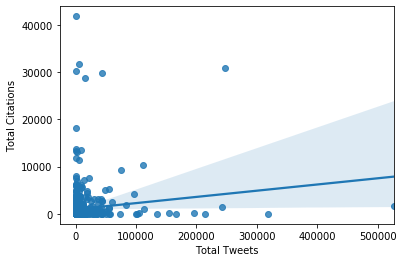

In [48]:
# scatter plot of average tweets per year against average citations per year
sns.regplot(x="tweets", y="total_citations", data=merged_df).set(xlabel='Total Tweets', ylabel='Total Citations')


There are obviously some serious outliers here. These should be filtered out to get a more representative sample. 

[Text(0, 0.5, 'Citations Per Year'), Text(0.5, 0, 'Tweets Per Year')]

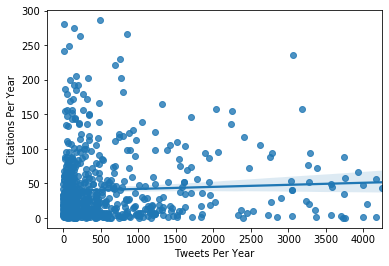

In [49]:
# removing outliers
cleaned_data = merged_df[merged_df['tweets_per_year'] < merged_df['tweets_per_year'].quantile(.95)]
cleaned_data = cleaned_data[cleaned_data['citations_per_year'] < cleaned_data['citations_per_year'].quantile(.95)]

# plot again but used metrics normazlized by time
sns.regplot(x="tweets_per_year", y="citations_per_year", data=cleaned_data).set(xlabel='Tweets Per Year', ylabel='Citations Per Year')

Using seaborn's pair plot option allows for a quick glance at many relationships between metrics and distributions of metrics. This will hopefully highlight anything strange or perhaps interesting.

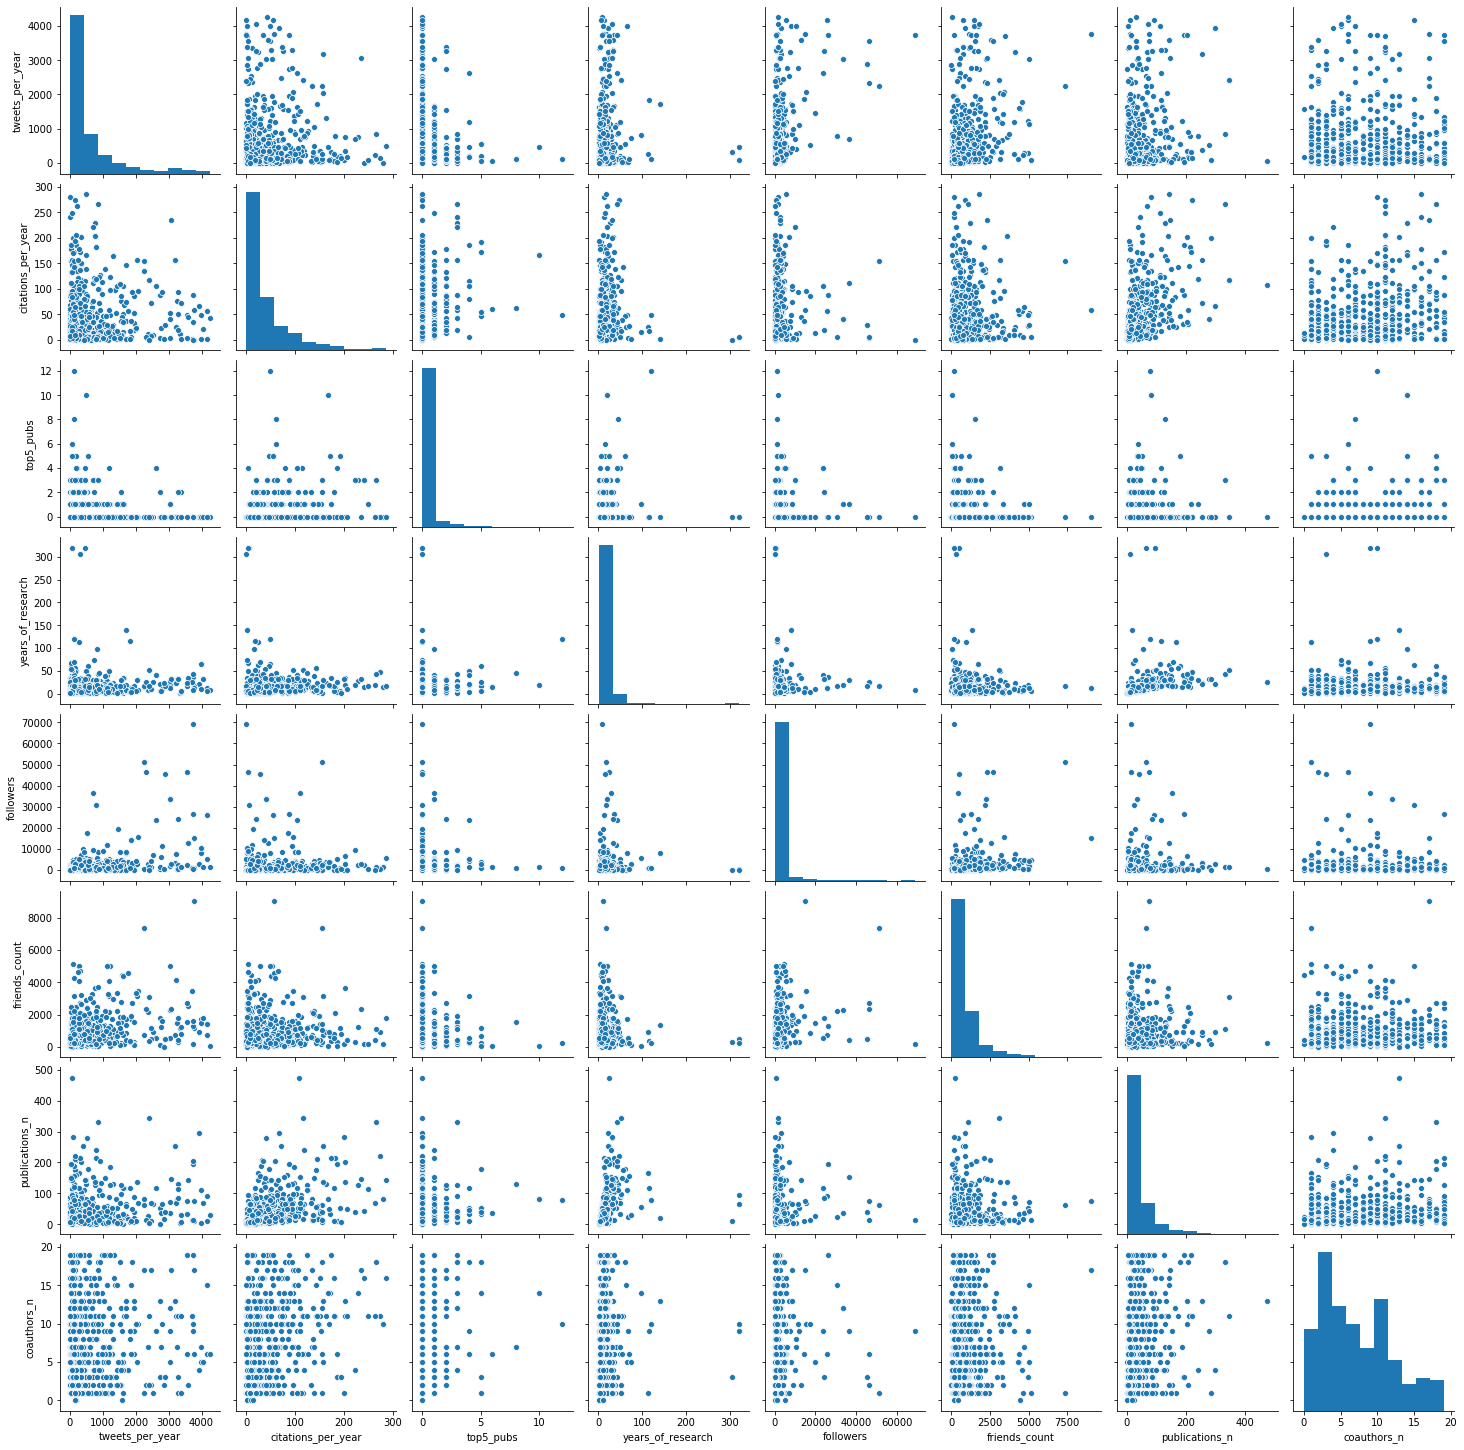

In [53]:
# plot a grid of scatter plots to visualize the various relationships between metrics
to_plot = cleaned_data[['tweets_per_year','citations_per_year',
                        'top5_pubs','years_of_research','followers',
                        'friends_count','publications_n','coauthors_n']]
sns.pairplot(to_plot)


None of the scatter plots reveal any particularly obvious relationships. Next, I'll run some regressions to parse out any statistically significant relationships that aren't apparent from the scatter plot. 

In [94]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

cleaned_data['const'] = 1
reg1 = sm.OLS(cleaned_data['citations_per_year'],cleaned_data[['tweets_per_day','followers',
                                                               'friends_count','coauthors_n',
                                                               'publications_n','top5_pubs',
                                                               'years_of_research']]).fit()
reg2 = sm.OLS(cleaned_data['citations_per_paper'],cleaned_data[['tweets_per_day','followers',
                                                               'friends_count','coauthors_n',
                                                               'publications_n','top5_pubs',
                                                               'years_of_research']]).fit()

print(summary_col([reg1,reg2],stars=True,float_format='%0.2f'))



                  citations_per_year citations_per_paper
--------------------------------------------------------
tweets_per_day    -1.85**            -0.41              
                  (0.78)             (0.35)             
followers         0.00               0.00               
                  (0.00)             (0.00)             
friends_count     0.00***            0.00***            
                  (0.00)             (0.00)             
coauthors_n       2.46***            1.14***            
                  (0.25)             (0.11)             
publications_n    0.49***            0.02               
                  (0.03)             (0.01)             
top5_pubs         10.81***           5.30***            
                  (1.53)             (0.69)             
years_of_research -0.23***           0.08***            
                  (0.07)             (0.03)             
R-squared         0.62               0.45               
                  0.62        

These regression results are quite interesting. They suggest academics who tweet at a higher frequency (tweets_per_day) have fewer citations per year on average (1 extra tweet per day on average is associated with 1.85 fewer citations per year) after controlling for follower, friends, number of coauthors, number of publications, number of top publications, and years of research experience. My take on this is that if you are stopping to tweet many times throughout the day, then your attention is constantly fragmented which limits your ability to perform the deep focus required for quality publications that go on to get cited heavily. 

Based on these results, I don't think I'll start tweeting.

